<a href="https://colab.research.google.com/github/saini-himanshu/emotion-ai/blob/main/FacialKeyPointsPrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
PATH =  "drive/MyDrive/Colab Notebooks/EmotionAI/"

In [ ]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
data = pd.read_csv(PATH+'Dataset/facial_keypoints_data.csv')

In [ ]:
data.head(1)

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,right_eye_outer_corner_x,right_eye_outer_corner_y,left_eyebrow_inner_end_x,left_eyebrow_inner_end_y,left_eyebrow_outer_end_x,left_eyebrow_outer_end_y,right_eyebrow_inner_end_x,right_eyebrow_inner_end_y,right_eyebrow_outer_end_x,right_eyebrow_outer_end_y,nose_tip_x,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y,Image
0,66.033564,39.002274,30.227008,36.421678,59.582075,39.647423,73.130346,39.969997,36.356571,37.389402,23.452872,37.389402,56.953263,29.033648,80.227128,32.228138,40.227609,29.002322,16.356379,29.647471,44.420571,57.066803,61.195308,79.970165,28.614496,77.388992,43.312602,72.935459,43.130707,84.485774,238 236 237 238 240 240 239 241 241 243 240 23...


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2140 entries, 0 to 2139
Data columns (total 31 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   left_eye_center_x          2140 non-null   float64
 1   left_eye_center_y          2140 non-null   float64
 2   right_eye_center_x         2140 non-null   float64
 3   right_eye_center_y         2140 non-null   float64
 4   left_eye_inner_corner_x    2140 non-null   float64
 5   left_eye_inner_corner_y    2140 non-null   float64
 6   left_eye_outer_corner_x    2140 non-null   float64
 7   left_eye_outer_corner_y    2140 non-null   float64
 8   right_eye_inner_corner_x   2140 non-null   float64
 9   right_eye_inner_corner_y   2140 non-null   float64
 10  right_eye_outer_corner_x   2140 non-null   float64
 11  right_eye_outer_corner_y   2140 non-null   float64
 12  left_eyebrow_inner_end_x   2140 non-null   float64
 13  left_eyebrow_inner_end_y   2140 non-null   float

In [ ]:
keypoints = data.iloc[:,:-1]
images = data.iloc[:,-1]

In [ ]:
keypoints.shape

(2140, 30)

In [ ]:
images.shape

(2140,)

In [ ]:
images = images.apply(lambda x: np.fromstring(x, dtype=int, sep=' ').reshape(96, 96))

In [ ]:
images[0].shape

(96, 96)

Some random Image visualizations

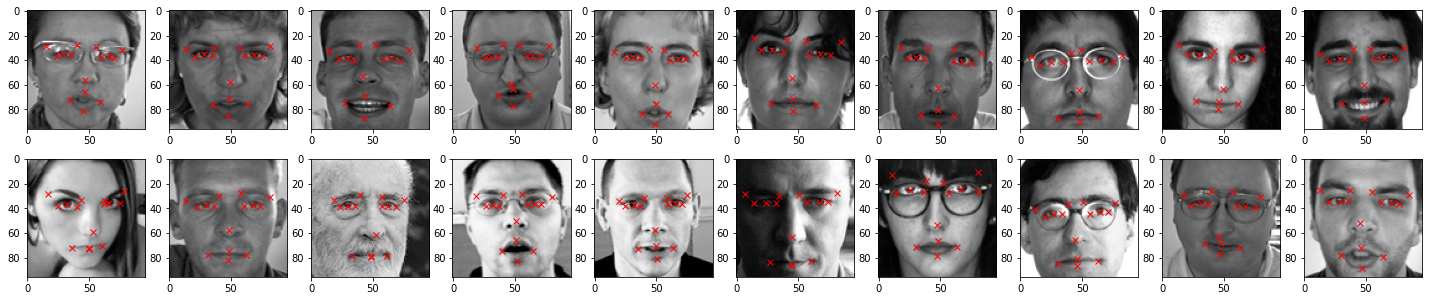

In [ ]:
fig = plt.figure(figsize=(25, 5))

for i in range(20):
    k = random.randint(1, len(images))
    ax = fig.add_subplot(2, 10, i + 1)    
    plt.imshow(images[k], cmap='gray')
    for j in range(1,31,2):
        plt.plot(keypoints.loc[k][j-1], keypoints.loc[k][j], 'rx')

In [ ]:
def apply_augmentation(images, keypoints):
    # Horizontal Flip
    horizontal_flip_images = images.apply(lambda x: np.flip(x, axis = 1))
    horizontal_flip_keypoints = keypoints.copy()
    for i in range(0,len(keypoints.columns),2):
        horizontal_flip_keypoints.iloc[i] = horizontal_flip_keypoints.iloc[i].apply(lambda x: 96. - float(x) )
    
    # Random Brightness
    random_brightness_images = images.apply(lambda x: np.clip(random.uniform(1.5, 2)* x, 0.0, 255.0))
    random_brightness_keypoints = keypoints.copy()
    
    # Horizontal Flip Random Brightness
    horizontal_flip_random_brightness_images = horizontal_flip_images.apply(lambda x: np.clip(random.uniform(1.5, 2)* x, 0.0, 255.0))
    horizontal_flip_random_brightness_keypoints = horizontal_flip_keypoints.copy()
    
    images = np.concatenate((images, horizontal_flip_images, random_brightness_images, horizontal_flip_random_brightness_images))
    keypoints = np.concatenate((keypoints, horizontal_flip_keypoints, random_brightness_keypoints, horizontal_flip_random_brightness_keypoints))
    return images, keypoints

In [ ]:
images, keypoints = apply_augmentation(images, keypoints)

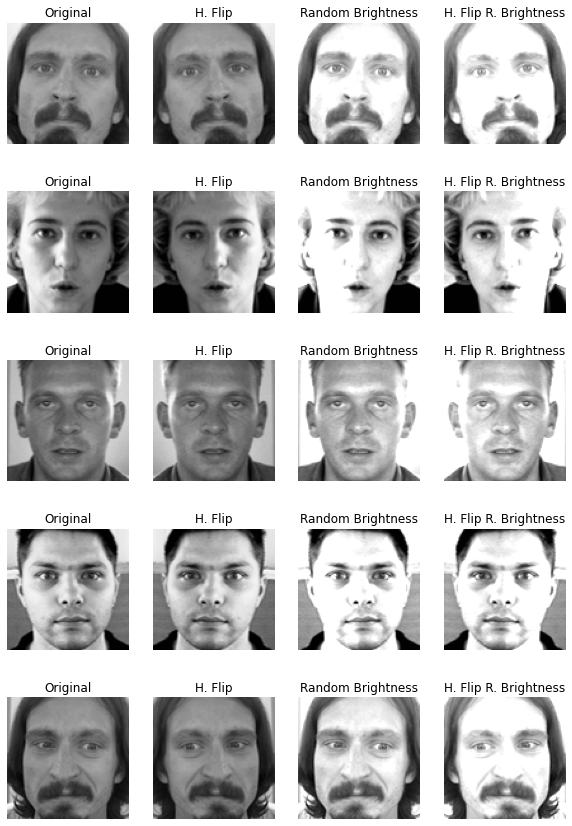

In [ ]:
fig = plt.figure(figsize=(10, 15))
s = data.shape[0]
k = 0
titles = ['Original', 'H. Flip', 'Random Brightness', 'H. Flip R. Brightness']
for i in range(5):
    for j in range(4):
        ax = fig.add_subplot(5, 4, k + 1)
        plt.imshow(images[(s*j)+i], cmap='gray')
        ax.set_title(titles[j])
        ax.axis('off')
        k += 1

In [ ]:
# Normalize the images
images = images/255.

# Create an empty array of shape (x, 96, 96, 1) to feed the model
X = np.empty((len(images), 96, 96, 1))

# Iterate through the img list and add image values to the empty array after expanding it's dimension from (96, 96) to (96, 96, 1)
for i in range(len(images)):
    X[i,] = np.expand_dims(images[i], axis = 2)

# Convert the array type to float32
X = np.asarray(X).astype(np.float32)
X.shape

(8560, 96, 96, 1)

In [ ]:
y = np.asarray(keypoints).astype(np.float32)
y.shape

(8560, 30)

In [ ]:
from sklearn.model_selection import train_test_split

# Split the data into train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras import Model

base_model = ResNet50(include_top=False, weights=None, input_shape=(96,96,1))

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)
# and a logistic layer -- let's say we have 200 classes
predictions = Dense(30, activation='relu')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

In [ ]:
model.compile(loss = "mean_squared_error", optimizer = "adam" , metrics = ['accuracy'])

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
earlystopping = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 2)
checkpointer = ModelCheckpoint(filepath=PATH+"KeyPoints_weights.hdf5", verbose=1, save_best_only=True)

In [ ]:
history = model.fit(X_train, y_train, batch_size = 32, epochs = 10, validation_split = 0.05, callbacks=[checkpointer, earlystopping])

Epoch 1/10
204/204 [==============================] - 30s 88ms/step - loss: 496.8161 - accuracy: 0.5449 - val_loss: 374.9515 - val_accuracy: 0.6822

Epoch 00001: val_loss improved from inf to 374.95148, saving model to KeyPoints_weights.hdf5
Epoch 2/10
204/204 [==============================] - 17s 81ms/step - loss: 283.4042 - accuracy: 0.7140 - val_loss: 313.1812 - val_accuracy: 0.6822

Epoch 00002: val_loss improved from 374.95148 to 313.18121, saving model to KeyPoints_weights.hdf5
Epoch 3/10
204/204 [==============================] - 17s 82ms/step - loss: 283.6758 - accuracy: 0.7234 - val_loss: 299.0627 - val_accuracy: 0.6793

Epoch 00003: val_loss improved from 313.18121 to 299.06271, saving model to KeyPoints_weights.hdf5
Epoch 4/10
204/204 [==============================] - 17s 83ms/step - loss: 281.6261 - accuracy: 0.7233 - val_loss: 285.9327 - val_accuracy: 0.7114

Epoch 00004: val_loss improved from 299.06271 to 285.93271, saving model to KeyPoints_weights.hdf5
Epoch 5/10
204

In [ ]:
# save the model architecture to json file for future use

model_json = model.to_json()
with open(PATH+"KeyPoints-model.json","w") as json_file:
    json_file.write(model_json)

In [ ]:
from tensorflow.keras.models import model_from_json

with open(PATH+'KeyPoints-model.json', 'r') as json_file:
    json_savedModel= json_file.read()
    
# load the model architecture 
model = model_from_json(json_savedModel)
model.load_weights(PATH+'KeyPoints_weights.hdf5')
model.compile(loss="mean_squared_error", optimizer="adam" , metrics=['accuracy'])

In [ ]:
# Evaluate the model

result = model.evaluate(X_test, y_test)
print("Accuracy : {}".format(result[1]))

54/54 [==============================] - 3s 27ms/step - loss: 202.0889 - accuracy: 0.7545
Accuracy : 0.7616822719573975


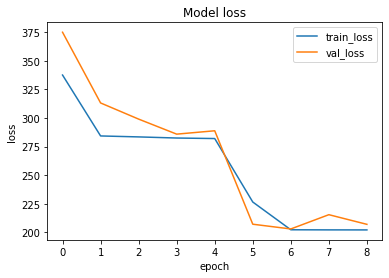

In [ ]:
# Plot the training artifacts

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss','val_loss'], loc = 'upper right')
plt.show()

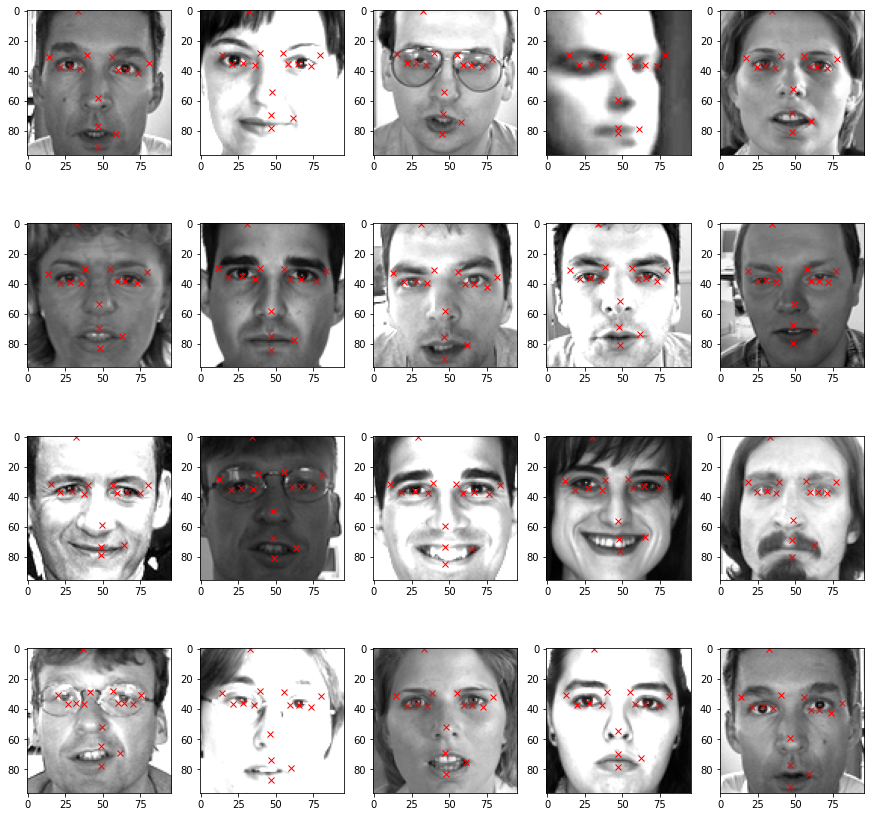

In [ ]:
predictions = pd.DataFrame(model.predict(X_test), columns=data.columns[:-1])

fig = plt.figure(figsize=(15, 15))

for i in range(20):
    ax = fig.add_subplot(4, 5, i + 1)    
    plt.imshow(X_test[i].squeeze(), cmap='gray')
    for j in range(1,31,2):
        plt.plot(predictions.loc[i][j-1], predictions.loc[i][j], 'rx')